In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-230.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [2]:
def load_qp_adm(path, infeasible=False):
    """Load, parse and return qp-Adm file.
    Return: 
    res: mxnx2 arryay: m: Nr subsets admixed pops, n: Nr 
    p_vals: List of m p-Values
    pops: List of Strings of analyzed populations. First is target, rest sources.
    infeasible: Whether to return infeasible as result"""
    pop_line, pop_line_end = -1, -1 # Where the populations are found   
    res_begin, res_end = -1, -1
    std_line = -1  # Where the standard Deviation will land
    
    # Iterate over everything and use the signals for start/stop
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if line =="left pops:\n":
                pop_line = i+1 
            if line=="right pops:\n":
                pop_line_end = i-1 # There is an empty line before
                
            # Parse off everything to first space
            s0 = line.split()
            if len(s0)>=2:
                #if s0[0] == "summ:":
                #    res_begin= i+3
                if s0[0] == "fixed" and s0[1]=="pat":
                    res_begin = i+1
                    
                if s0[0] == "best" and s0[1]=="pat:":
                    if res_end < 0: # Only take the first occurence
                        res_end = i
                        
                elif s0[0] == "std." and s0[1]=="errors:":
                    std_line = i
    
    ### Read out the results:
    with open(path, "r") as f:
        lines = f.readlines()
        pops = lines[pop_line:pop_line_end]
        pops = [p.rstrip() for p in pops]  # Chews off new line symbol

        res = lines[res_begin:res_end]
        stds = lines[std_line]
    
    # Post-process the important Lines:
    res_t = np.array([s.split()[:len(pops)+4] for s in res]) # 8 is valid for 3 pops!
    res = res_t[:,5:].astype("float")
    p_vals = res_t[:,4].astype("float")
    stds = np.array(stds.split())[2:].astype("float")  # Extract the Standard Deviations for the first line
            
    # Read out estimates and p-Value
    assert(len(p_vals)==len(res)) # Sanity Check
    return res, p_vals, pops, stds
    

def load_pvals(path):
    """Load and parse qpAdm log file for p-Value.
    Return: 
    p-val:  p-Value
    pops: [Target, Source]"""
    
    pop_line, pop_line_end = -1, -1 # Where the populations are found   
    p_val_line = -1
    
    # Iterate over everything and use the signals for start/stop
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if line =="left pops:\n":
                pop_line = i+1 
            if line=="right pops:\n":
                pop_line_end = i-1 # There is an empty line before
                
            if line=="codimension 1\n":
                p_val_line = i+2
    
    ### Read out the results:
    with open(path, "r") as f:
        lines = f.readlines()
        pops = lines[pop_line:pop_line_end]
        pops = [p.rstrip() for p in pops]  # Chews off new line symbol

        pval = lines[p_val_line].split()[7]
          
    return float(pval), pops   


def fig_admix(axes=[], res=[], p_vals=[], target_pops=[], 
              source_pops=[], figsize=(12,8), 
              save_path="", lw=2,
              pval_lim=[1e-6,1.0], stds=[], 
              l_pos = (1, 0.5), fs = 12, bw = 0.85, 
              c=[], ec = "white", show=False,
              height_ratios=[1, 8], xlabels=[],
              rotation=90, legend=True):
    """Make a Figure of the admixture coefficients.
    axes: 2 axis where to plot Fractions and p-Values onto
    res: nxk Array of Results
    p_vals: Array of p-Vals [n]
    target_pops: String Array of Target Pops [n]
    source_pops: String Array of Source Pops [k]
    stds: Standard Errors. If none are given do not plot them
    l_pos: Where to place the Legend.
    lw: Linewidth of bar"""
    # Create Pandas Dataframe for Plot
    #pd.DataFrame(data=target_pops, index=r, columns=source_pops)
    
    ### Define Axes if not given
    if len(axes)==0:
        fig, axes = plt.subplots(nrows=2, ncols=1,
                                 gridspec_kw={'height_ratios': height_ratios}, 
                                 figsize=figsize)
    ax0, ax1 = axes
    
    # Plot Parameters
    r = np.arange(len(target_pops))
    barWidth = bw
    if len(c)==0:
        c=["DeepPink", "MediumBlue", "purple", "yellowgreen", "gold"]
    
    for i, s in reversed(list(enumerate(source_pops))): # From last to first (For Legend)
        s = source_pops[i]
        b = np.sum(res[:,:i], axis=1)
        ax1.bar(r, res[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=s, alpha=0.9)
        
        if len(stds)>0: # Plot some standard deviations.
            ax1.errorbar(r, b+res[:,i], yerr=stds[:,i], fmt='none', linewidth=lw, color="k")
    
    ### Add the Model not viable bars:
    su = np.sum(res, axis=1)
    sum0ids = np.where(su==0)[0]
    
    for i in sum0ids:
        ax1.bar(i, 1, color="lightgray", edgecolor='white', width=barWidth, alpha=0.9)
     
    ################
    # Custom x axis
    ax1.set_xticks(r)
    
    if len(xlabels)==0:
        xlabels = target_pops
    ax1.set_xticklabels(xlabels, fontsize=fs, rotation=rotation)

    # Add a legend
    #l1 = ax1.legend(loc=l_pos, bbox_to_anchor=(1, 0.5), ncol=1, fontsize=fs)
    if legend:
        l1 = ax1.legend(bbox_to_anchor=l_pos, ncol=1, fontsize=fs)
        l1.set_title('Sources: ', prop={'size':fs})
    
    ax1.set_ylabel("Fraction Ancestry", fontsize=fs*1.5)
    ax1.set_ylim([0,1])
    ax1.set_xlim([-0.6, len(target_pops)-0.4])
    
    ax0.set_yscale("log")
    ax0.set_ylim(pval_lim)
    ax0.bar(r, p_vals, color="grey", width=barWidth, alpha=0.8, zorder=1)
    ax0.axhline(y=0.05, color='r', zorder=0)
    ax0.set_ylabel("p-Val", fontsize=fs)
    ax0.set_xlim([-0.6,len(target_pops)-0.4])
    ax0.set_xticks([])
    
    # Adjust position of subplots
    #plt.subplots_adjust(left=0, bottom=0.05, right=None,
    #            wspace=0, hspace=0.06)
    
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    
    if show:
        plt.show()

def create_admix_df(source_pops, admix_coeffs, stds, p_vals):
    """Create Dataframe with Admixture Proportions and Standard Errors.
    Assume all input is as Numpy Array (otherwise indexing errors!!)"""
    n = len(source_pops[0,:])  # Get Number Sources +1
    df = pd.DataFrame({"target":source_pops[:,0], "p-Value":p_vals})
    
    for i in range(1,n):
        df[f"Source_{i}"] = source_pops[:,i]
        
    for i in range(1,n):
        df[f"Fraction_{i}"] = admix_coeffs[:,i-1]
        
    for i in range(1,n):
        df[f"STD_{i}"] = stds[:,i-1]
    return df
    
def give_admix0(res, minval=-1e-4):
    """Return the Admixture Coefficients of the first Model.
    Only return 0 if feasible, else nana"""
    
    feasible = np.min(res[0])>minval  # Check if feasible
    if feasible == 0:
        return np.nan  # No Feasible Model
    return 0
    
def give_admix_index(res):
    """Return index of first viable admixture result.
    res: nxk array. n...Nr of all subsets, k...Nr of Source Pops"""    
    for i, ls in enumerate(res):
        if np.min(ls)>-1e-4:
            return i
    print("Warning: No valid admixture found!!")       
    return np.nan # Default Return

def give_admix_index_best(res, pvals, minval=-1e-4):
    """Return index of best viable admixture result.
    res: nxk array. n...Nr of all subsets, k...Nr of Source Pops"""  
    feasible = np.min(res, axis=1)>minval  # Extract all feasible results
    pvals_okay = feasible * pvals  # Set bad ones to 0.
    
    if np.max(pvals_okay)==0:
        print("Warning: No valid admixture found!!")
        return np.nan
    
    i = np.argmax(pvals_okay) # The Index with the Maximum Value
    return i
    
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if not exponent:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits

    return "${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)


def create_latex_lines(source_pops, admix_coeffs, stds, p_vals, na = "-", rp = "A12"):
    """Print a Line for Latex Table in the main Text. 
    Script to speed things up.
    source_pops, nx(j+1) Array, j...NR of Sources (<=3)
    admix_coeffs, stds: nxj Array
    p_vals: nx1 Array
    na: Character for Missing Data
    rp: String for right population"""
    out =""
    
    for i in range(len(source_pops)): # Iterate over every line
        ls = [na for _ in range(12)] # Create empty vector with na Symbol
        
        assert(len(source_pops[i])<=4) # At most 4 sources
        
        for j, s in enumerate(source_pops[i]): # Fill in the Source Populations
            ls[j] = s   
            
        ls[4] = rp        # Right Pop
        
        p = p_vals[i]
        
        if p==0.0:
            ls[5] = "0" 
        elif p>=0.05:
            ls[5] = "\\textbf{" +  str(np.around(p, 3)) + "}" # Make bold
            
        elif p>= 0.01:
            ls[5] = np.around(p, 3) # Round to three Digits            
        elif p<0.01: 
            ls[5] = sci_notation(p, decimal_digits=1)  # Do proper formatting      
        
        for j, x in enumerate(admix_coeffs[i]): # Fill in the admixture fractions
            ls[6+j] = "{:.3f}".format(x) 
            
        for j, x in enumerate(stds[i]): # Fill in the uncertainty of admixture fractions
            ls[9+j] = "{:.3f}".format(x)        
        
        s = " & ".join(str(x) for x in ls) # Convert to Strings and Join
        s=s.replace("_", "-") # Replace tricky underscore symbols (for Latex tables)
        print(s + "\\\\") # Add two backslashes
        out += (s + "\n") # Do next Line
        
    return out # Return the full text

def load_iids_from_indfile(path_ind, string, 
                           col="clst", col_iid="iid",
                           iids_okay=[]):
    """Load IIDs from Ind File
    Return List of IIDs"""
    df_ind = pd.read_csv(path_ind, delim_whitespace=True, header=None)
    df_ind.columns=["iid", "sex","clst"]
    idx = df_ind[col].str.contains(string)
    ls = df_ind[idx][col_iid].values
    
    ### If needed filter out okay Individuals
    if len(iids_okay)>0:
        ls = np.intersect1d(ls, iids_okay)
    return ls

###################################################
### Load okay Individual IIDs

def load_individuals_filetered(
                            path_anno = "/n/groups/reich/hringbauer/Data/v42.3.anno.csv",
                            col="clst", col_iid="iid",
                            min_snps_cov=50000,
                            snp_cov_col="n_cov_snp",
                            master_id_col="Master ID",
                            ):
    """Filter List of Individuals against meta,
    using minimal Nr of SNPs and unique IDs"""

    df_all = pd.read_csv(path_anno)

    ### Keep only the best coerage Indivdual
    df_all = df_all.sort_values(by=snp_cov_col, ascending=False)
    df_all = df_all.drop_duplicates(subset=master_id_col)
    
    ### Filter to min Nr of SNPs
    df_all = df_all[df_all[snp_cov_col]>=min_snps_cov]
    
    ### 
    df_all = df_all
    return df_all["iid"].values


###################################################
###################################################
### Plot functions

def plot_qpadm(dir_path, test_pops, save_path="", l_pos = (0.4, 1.15), 
               best=True, figsize=(12,8), bw = 0.85, lw=2,
               height_ratios = [1,8], xlabels=[],
               c=[], ec="white", fs=10, pval_lim = [1e-3,1],
               latex=False, dataframe=False):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, 
    True use the best p-Value, 
    else use the old (first feasible)"""
    admix_coeffs = []
    p_vals = []
    pops_t = [] 
    stds = []
    pr = False # Print the statistics

    #for filename in os.listdir(dir_path):
    for f in test_pops:
        full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
        res, p_val_ls, pops, std = load_qp_adm(full_path)

        pops_t.append(pops[0])
        
        if best == 0:
            i = give_admix0(res)   # Give the first result (if feasible)
            
        elif best == True:
            i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value
        
        else:
            i = give_admix_index(res)
            
        #### Handle Not fitting Models  
        if np.isnan(i): # In Case no valid admixture:
            new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
            std = np.zeros(np.shape(res)[1])     # Not Plot anything
            new_p = -1 # For Sorting
        
        else:
            new_res = res[i,:]
            new_p = p_val_ls[i]
        
        admix_coeffs.append(new_res)
        p_vals.append(new_p)
        stds.append(std)

        if pr == True:
            print("Population: %s" % f)
            print(res[i,:])
            print(std)
            print(p_val_ls[i])

    admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
    source_pops = pops[1:]
    
    print(pops_t)
    
    fig_admix(res=admix_coeffs, 
              p_vals=p_vals, 
              target_pops=pops_t, 
              source_pops=source_pops, 
              pval_lim=pval_lim, 
              stds=stds, save_path = save_path, 
              l_pos = l_pos, lw=lw, xlabels=xlabels,
              height_ratios=height_ratios,
              fs=fs, figsize=figsize, 
              bw = bw, c=c, ec = ec)
    
    if latex:
        source_pops = [([t] + pops[1:]) for t in pops_t]
        create_latex_lines(source_pops, admix_coeffs, stds, 
                           p_vals, na = "-", rp = "A15")
        
    if dataframe:
        source_pops = np.array([([t] + pops[1:]) for t in pops_t])
        df = create_admix_df(source_pops, admix_coeffs, stds, p_vals)
        return(df)
    
    
def plot_qpadm_split(dir_path, test_pops=[[]], 
                     save_path="", 
                     best=True, figsize=(12,8),
                     labels=[],
                     bw = 0.85, lw=2,
                     c=[], ec="white", fs=10, 
                     height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                     pval_lim = [1e-3, 1], pr=False,
                     legend=True, l_pos=[]):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, True use the best p-Value, 
    else use the old (first feasible)
    test_pops: List of lists: Will be split up into subdataframes
    pr: whether to print output"""
    
    ### Prepare the Plots
    width_ratios = [len(ls) for ls in test_pops]
    
    fig = plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, len(test_pops), 
                           width_ratios = width_ratios, 
                           height_ratios = height_ratios, 
                           figure = fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    for j, ls in enumerate(test_pops):        
        # make empty vectors for loading and plotting
        admix_coeffs = []
        p_vals = []
        pops_t = [] 
        stds = []
    
        for f in ls:
            full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
            res, p_val_ls, pops, std = load_qp_adm(full_path)

            pops_t.append(pops[0])

            if best == 0:
                i = give_admix0(res)   # Give the first result (if feasible)

            elif best == True:
                i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value

            else:
                i = give_admix_index(res)

            #### Handle Not fitting Models  
            if np.isnan(i): # In Case no valid admixture:
                new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
                std = np.zeros(np.shape(res)[1])     # Not Plot anything
                new_p = -1 # For Sorting

            else:
                new_res = res[i,:]
                new_p = p_val_ls[i]

            admix_coeffs.append(new_res)
            p_vals.append(new_p)
            stds.append(std)

            if pr == True:
                print("Population: %s" % f)
                print(res[i,:])
                print(std)
                print(p_val_ls[i])
        
        ### Do the actual Plot
        ax_adm = fig.add_subplot(gs[0, j])
        ax_p = fig.add_subplot(gs[1, j])
        
        #ax_adm = plt.subplot(gs[0, i])
        #ax_p = plt.subplot(gs[1, i])
        
        admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
        source_pops = pops[1:]
        if j>0:
            legend=False
            
        fig_admix(axes=[ax_adm, ax_p], res=admix_coeffs, 
                  p_vals=p_vals, 
                  target_pops=pops_t, 
                  source_pops=source_pops, 
                  pval_lim=pval_lim, 
                  stds=stds, save_path = "", 
                  lw=lw, 
                  fs=fs, figsize=figsize, 
                  bw = bw, c=c, ec = ec, show=False,
                  legend=legend, l_pos = l_pos)
        
        ### Turn off the Labels for all but first plot
        if j>0:
            for ax in [ax_p, ax_adm]:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                
        if len(labels)>0:
                ax_adm.set_title(labels[j], fontsize=fs)
            
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', 
                    pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    plt.show()

# Plot the European Sources with Afr. Cline End fixed

['PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline']


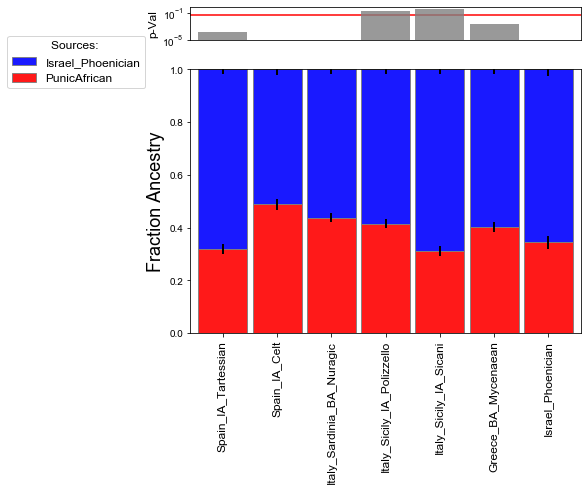

In [3]:
### Load the ancient Individual Label Data
target = "PunicCline"  # The Sicilian "inbred individual"
s1 = "PunicAfrican"

sources2 = ["Spain_IA_Tartessian", "Spain_IA_Celt", "Italy_Sardinia_BA_Nuragic", 
            "Italy_Sicily_IA_Polizzello", "Italy_Sicily_IA_Sicani", 
            "Greece_BA_Mycenaean", "Israel_Phoenician"]


paths = [".".join([target, s1, s2]) for s2 in sources2]

dir_path = "./output/qpAdm/v46.3/eu_source/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["red", "blue"]

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=sources2,
           best=False, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, 
           fs=12, c=c, ec="gray", l_pos=(-0.1, 1.15))

# Plot African Source with Polizello fixed

['PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline', 'PunicCline']


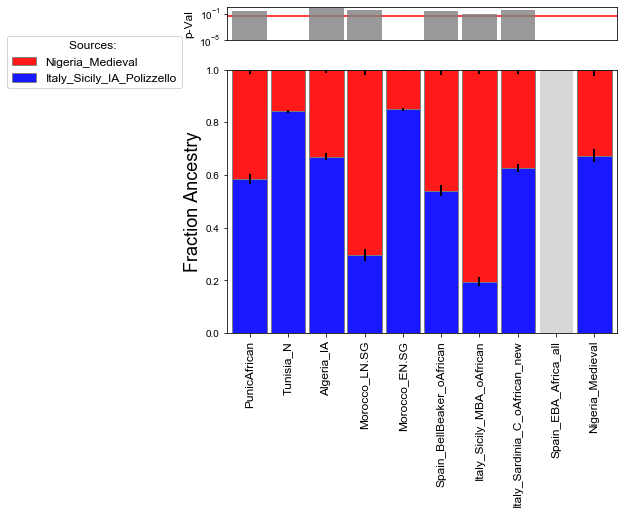

In [24]:
### Load the ancient Individual Label Data
target = "PunicCline"  # The Sicilian "inbred individual"
s1 = "Italy_Sicily_IA_Polizzello"

sources2 = ["PunicAfrican", "Tunisia_N", "Algeria_IA", "Morocco_LN.SG", "Morocco_EN.SG",
           "Spain_BellBeaker_oAfrican", "Italy_Sicily_MBA_oAfrican", 
            "Italy_Sardinia_C_oAfrican_new", "Spain_EBA_Africa_all", "Nigeria_Medieval"] 


paths = [".".join([target, s1, s2]) for s2 in sources2]

dir_path = "./output/qpAdm/v46.3/afr_source/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["blue", "red"]

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=sources2,
           best=False, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, 
           fs=12, c=c, ec="gray", l_pos=(-0.1, 1.15))

# Distal models with Iran-N

In [5]:
all_iids = ["I18195", "MSR002", "I4798", "I12666"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA",
           "I12433", "Israel_MLBA_Canaanite"]
paths = [str(iid) + ".5way" for iid in all_iids]

In [99]:
### Load the ancient Individual Label Data
pops = ["Morocco_LN", "Iberia_North_BA_Africa_all",
        "Punic_oAfrican"] #"Sardinia"
path_ind = "./eigenstrat/combined/punic1.v43.ind"

all_iids = [load_iids_from_indfile(path_ind=path_ind, 
                        string=pop) for pop in pops]

all_iids = np.concatenate(all_iids)
all_iids = np.insert(all_iids, 3, "I4246")
paths = [".".join([iid, "Anatolia_N","WHG", "Steppe_EMBA", "I12433"]) for iid in all_iids]

Saved to ./figures/qpAdm/4way_Canaanite_AfrIA.pdf


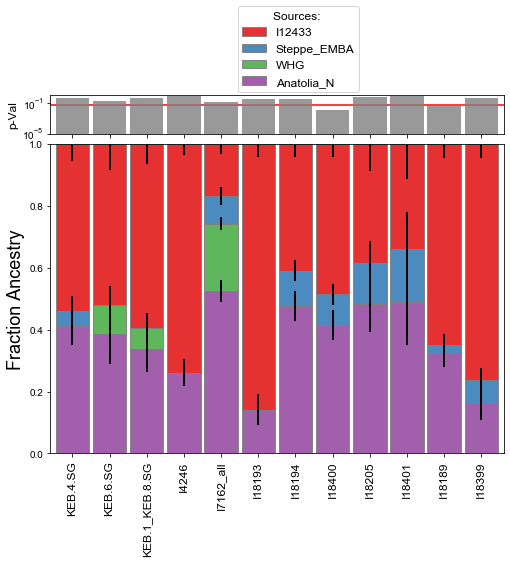

In [100]:
dir_path = "./output/qpAdm/4way_p_Canaanite/"
save_path = "./figures/qpAdm/4way_Canaanite_AfrIA.pdf"
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c"]

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path, 
            best=True, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, 
            fs=12, c=c, ec="gray")

# Plot AFrican Admixture

In [181]:
"Iberia_Iberian", "Iberia_Celtiberian",
"Iberia_Tartessian",
#"Italy_Sardinia_C_o",
"Italy_Sardinia_BA_Nuragic", "Iberia_IA", "Iberia_BA"

('Italy_Sardinia_BA_Nuragic', 'Iberia_IA', 'Iberia_BA')

In [ ]:
### Load the ancient Individual Label Data
path_ind = "./eigenstrat/combined/punic1.v43.ind"
iids = load_individuals_filetered(path_anno='/n/groups/reich/hringbauer/Data/v42.3.anno.csv',
                                 min_snps_cov=1e5)

pops_na = ["Morocco_LN"]
pops_ib_outliers = ["Italy_Sardinia_C_o"]
pops_vil = ["Iberia_Punic_o.3rd", "Iberia_Punic_oEuropean", 
            "Iberia_Punic_o3","Iberia_Punic_oAfrican"]
pops_ibiza = ["Ibiza_Punic"]
pops_nur = ["Italy_Sardinia_BA_Nuragic"]
pops_tar = ["Iberia_Tartessian"]
pops_ib = ["Iberia_Iberian"]
pop_pol = ["Sicily_IA_Polizzello"]
pop_sic = ["Sicani"]
pops_clt =  ["Iberia_Celtiberian"]
pops_nur = ["Nuragic"]

### Add Monte Sirari and Villamar
cadir_inds = ["I12517", "I15434"]
msr_inds = ["MSR002", "MSR003"]
vil_inds = ["VIL004", "VIL006", "VIL007", 
            "VIL009", "VIL010", "VIL011"]
motya_inds= ["I4800", "I4798", "I4799",
            "I7762", "I7650", "I12844"]
birgi_inds = ["I12847", "I12665", "I12666"]
marsala_inds = ["I12846", "I12848", "I7454", "I8577"]
palermo_inds = ["I7764", "I7765"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]

pops = [pops_na, pops_ib_outliers, 
        pops_clt, pops_ib, pops_tar,
        pops_nur, pops_vil, pops_ibiza]

all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
all_iids = [np.concatenate(ls) for ls in all_iids]
all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[".".join([iid]+sources) for iid in ls] for ls in all_iids]
labels = ["Morocco\nLN", "CA\nOutliers",
          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
          "Sardinia BA\nNuragic","Villaricos\nPunic", "Ibiza\nPun.", 
          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

Saved to ./figures/qpAdm/north_african.pdf


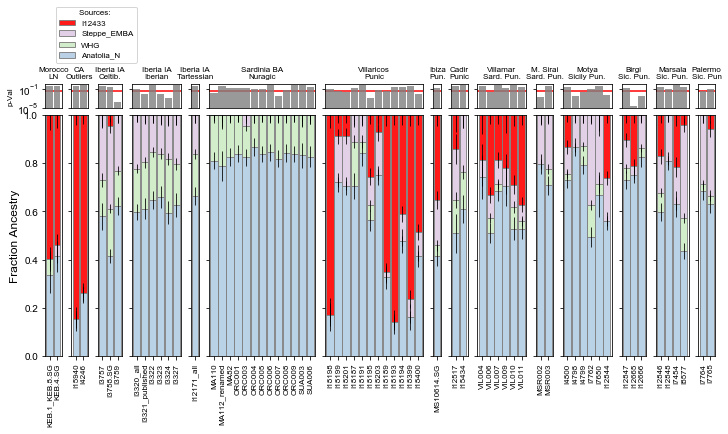

In [33]:
dir_path = "./output/qpAdm/4way_p_Canaanite/"
#save_path = "./figures/qpAdm/4way_Canaanite_AfrIA.pdf"
save_path = "./figures/qpAdm/north_african.pdf"

c = ["#b3cde3", "#ccebc5", "#decbe4", "red"]

plot_qpadm_split(dir_path=dir_path, test_pops=paths, 
                 save_path=save_path, labels=labels,
                 best=True, pval_lim = [1e-5,1], 
                 figsize=(12,5), bw=0.9, 
                 height_ratios=[1, 10],
                 hspace=0.05, wspace=0.28,
                 fs=8, c=c, ec="gray", lw=0.8,
                 l_pos = (0.4, 1.2)
                 )

# Plot North African v44

In [39]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="clst"):
    """Get Sub Populations"""
    idx = df[pop_col].str.contains("|".join(pop_list))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df["iid"].values

def get_sub_iid(df, pops=[""], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(pops))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df["iid"].values

def get_sub_pops_exact(df, pop_list=[], pop_col="clst"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df["iid"].values

In [40]:
min_snp = 30000
ind_merged="./eigenstrat/combined/punic.v44.ind"          # What .ind to load
df = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df.columns=["iid", "sex", "clst"]
df = remove_individuals(df, remove_list=["_d"])
print(f"Loaded {len(df)} Individuals")

df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v44.0.anno.csv", sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", "mean_cov", "sex"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

Filtering to 1037/1150
Loaded 1037 Individuals
Filtered to 980 Individuals based on Min SNP: 30000
Filtered to 912 based on duplicates


In [70]:
### Load the ancient Individual Label Data
path_ind = "./eigenstrat/combined/punic.v44.ind"
iids = load_individuals_filetered(path_anno='/n/groups/reich/hringbauer/Data/v42.3.anno.csv',
                                 min_snps_cov=1e5)

#pops = [,
#        , "Ibiza_Punic.SG", 
#        ] # "Greece_BA_Mycenaean"

pops1 = ["Villaricos", "Sicily_Himera", "Menorca"]

#df1 = get_sub_pops_exact(df, pop_list=pops)
#df2 = get_sub_pops(df, pops1)
#df3 = get_sub_iid(df, iids)

pops_con = [["Spain_IA"], ["Italy_Sicily_IA_Polizzello"], ["Italy_Sardinia_BA_Nuragic"]]
context_iids = [get_sub_pops_exact(df,p) for p in pops_con]

iids = ["VIL", "MSR"] # "I12517|I15434|I8135" Cadir
sar_iids0 = [get_sub_iid(df, [l]) for l in iids]

iids = ["I12517|I15434|I8135"]
car_iids = [get_sub_iid(df, [l]) for l in iids]

pops = [["Villaricos"]]
vil_iids = [get_sub_pops(df, p, pop_col="loc") for p in pops]

pops = [["Italy_Sardinia_Punic", "Italy_Sardinia_Punic_Roman"], ["Italy_Phoenician_Sicily", "Italy_Sicily_Punic"]]
punic_iids = [get_sub_pops_exact(df,p) for p in pops]

all_iids = context_iids + car_iids + vil_iids + sar_iids0 + punic_iids

### Add Monte Sirari and Villamar
cadir_inds = ["I12517", "I15434"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]

#all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
#                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
#all_iids = [np.concatenate(ls) for ls in all_iids]
#all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
#all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[".".join([iid]+sources) for iid in ls] for ls in all_iids]
labels = ["Spain IA", "Polizzello\nSicily IA", "Nuragic\nSardinia", "Cadir\nSp. Punic", "Villaricos\nSp. Pun.", 
          "Villamar \nSa. Pun.", "M. Sirai \nSa. Pun.", "Tharros \nSard. Pun.", "Sicily \nPunic"]
#labels = ["Morocco\nLN", "CA\nOutliers",
#          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
#          "Sardinia BA\nNuragic","Villaricos\nPunic", "Ibiza\nPun.", 
#          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
#          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
#          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

Found: 19/912
Found: 19/912
Found: 10/912
Found: 6/912
Found: 2/912
Found: 3/912
Found: 10/912
Found: 19/912
Found: 35/912


Saved to ./figures/qpAdm/north_african_v44.pdf


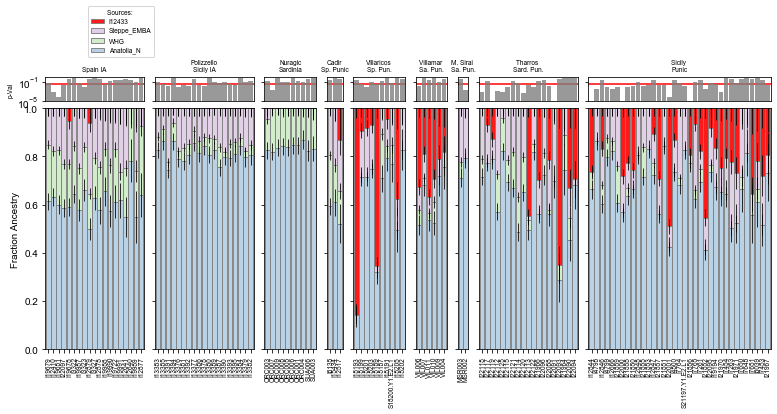

In [76]:
dir_path = "./output/qpAdm/v44/4way_r_canaanite/"
save_path = "./figures/qpAdm/north_african_v44.pdf" # ./figures/qpAdm/north_african.pdf

c = ["#b3cde3", "#ccebc5", "#decbe4", "red"]

plot_qpadm_split(dir_path=dir_path, test_pops=paths, 
                 save_path=save_path, labels=labels,
                 best=True, pval_lim = [1e-5,1], 
                 figsize=(13,5), bw=0.9, 
                 height_ratios=[1, 10],
                 hspace=0.05, wspace=0.15,
                 fs=6.5, c=c, ec="gray", lw=0.8,
                 l_pos = (0.4, 1.2)
                 )

# Plot all Individuals, distal Models
(Morocco_EN, Iran_N, Steppe_EMBA, WHG, Anatolia_N)

Saved to ./figures/qpAdm/distal_5way_all.png


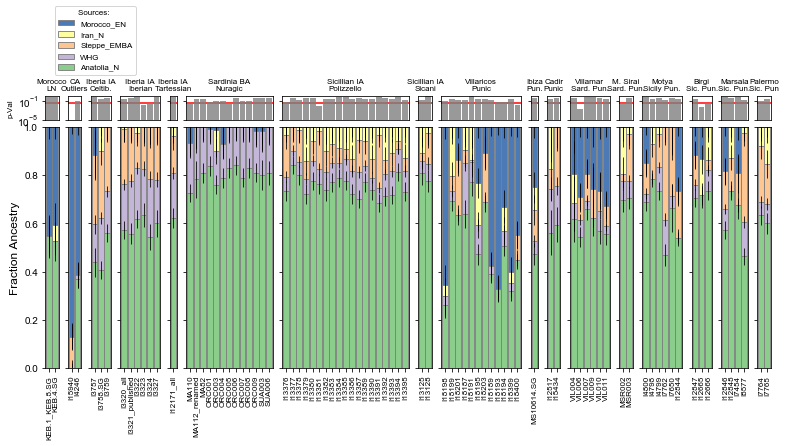

In [10]:
# Run the above Cell with pop definitions!
#sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]
dir_path = "./output/qpAdm/5wayAll/"
save_path = "./figures/qpAdm/distal_5way_all.png"
c = ["#7fc97f", "#beaed4", "#fdc086", 
     "#ffff99", "#386cb0"]

pops = [pops_na, pops_ib_outliers, 
        pops_clt, pops_ib, pops_tar,
        pops_nur, pop_pol, pop_sic, pops_vil, pops_ibiza]

all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
all_iids = [np.concatenate(ls) for ls in all_iids]
all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[str(iid)+".5way" for iid in ls] for ls in all_iids]
labels = ["Morocco\nLN", "CA\nOutliers",
          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
          "Sardinia BA\nNuragic", "Sicillian IA\nPolizzello", "Sicillian IA\nSicani", "Villaricos\nPunic", "Ibiza\nPun.", 
          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

plot_qpadm_split(dir_path=dir_path, test_pops=paths, 
                 save_path=save_path, labels=labels,
                 best=True, pval_lim = [1e-5,1], 
                 figsize=(13,5), bw=0.9, 
                 height_ratios=[1, 10],
                 hspace=0.05, wspace=0.28,
                 fs=8, c=c, ec="gray", lw=0.8,
                 l_pos = (0.4, 1.2)
                 )

# Plot Sicillians admixture analysis

In [25]:
### Load and sort Iberian Punic Individuals
plot_pop = "Sicily_Phoenician"  # Iberia_Punic

anno_path = "/n/groups/reich/hringbauer/explore_ntbk/v42/V42.3/v42.3.anno"
df = pd.read_csv(anno_path, sep='\t', low_memory=False)
cov_col1 = "SNPs hit on autosomal targets"
clst_col = 'Group_ID (format convention which we try to adhere to is "Country_<Geographic.Region_<Geographic.Subregion_>><Archaeological.Period.Or.DateBP_<Alternative.Archaeological.Period_>><Archaeological.Culture_<Alternative.Archaeological.Culture>><genetic.subgrouping.index.if.necessary_><"o_"sometimes.with.additional.detail.if.an.outlier><additional.suffix.especially.relative.status.if.we.recommend.removing.from.main.analysis.grouping><"contam_".if.contaminated><"lc_".if.<15000.SNPs.on.autosomal.targets><".SG".or.".DG".if.shotgun.data>; HG=hunter-gatherer, N=Neolithic, C=Chalcolithic/CopperAge, BA=BronzeAge, IA=IronAge, E=Early, M=Middle, L=Late, A=Antiquity)'
df_ibpun = df[df[clst_col].str.contains(plot_pop)]
df_ibpun = df_ibpun[~df_ibpun[clst_col].str.contains("_contam")] # Remove the contaminated ones
#df_ibpun[core_cols].sort_values(by=age_col, ascending=False)[core_cols][:50]
df_ibpun = df_ibpun.sort_values(by="Master ID")  # "Locality"
df_ibpun = df_ibpun[df_ibpun[cov_col1]>50000]
all_iids = df_ibpun["Master ID"]

#all_iids = np.insert(all_iids, 3, "I4246")
paths = [".".join([iid, "Anatolia_N","WHG", "Steppe_EMBA", "I12433"]) for iid in all_iids] # I12433 #I4246

Saved to ./figures/qpAdm/Sicily_distal_o_Canaanite.pdf


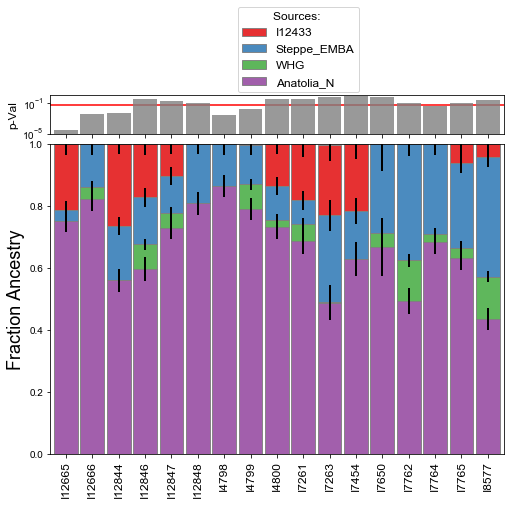

Finished


In [27]:
dir_path = "./output/qpAdm/4way_Ib_o_Canaanite/"
dir_path = "./output/qpAdm/4way_p_Canaanite/"   # With Morocco_N as outlier
save_path = "./figures/qpAdm/Sicily_distal_o_Canaanite.pdf" #./figures/qpAdm/4way_Canaanite_Ib_o_Canaanite.pdf
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c"]

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path, 
            best=True, pval_lim = [1e-5,1], figsize=(7,6), bw=0.9, 
            fs=12, c=c, ec="gray")

In [ ]:
dir_path = "./output/qpAdm/3wayNAf/"
save_path = ""
c = ["#b3cde3", "#ccebc5", "red"]

#best=0, pval_lim = [1e-4,1], figsize=(6,6)
test_pops = [paths, paths]
plot_qpadm_split(dir_path=dir_path, test_pops=test_pops, 
                 save_path=save_path, 
                 best=False, pval_lim = [1e-5,1], 
                 figsize=(7,6), bw=0.9, 
                 height_ratios=[1, 10],
                 hspace=0.03, wspace=0.03,
                 fs=12, c=c, ec="gray")

# Plot 3-way Models for Empuries

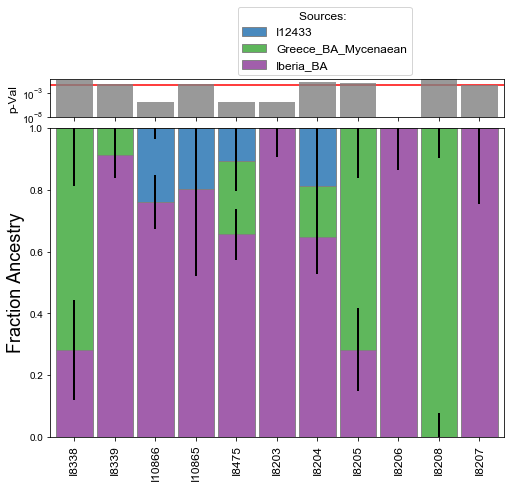

In [16]:
### Load the ancient Individual Label Data
pops = ["Iberia_Greek", "Iberia_Hellenistic"]
path_ind = "./eigenstrat/combined/punic1.v43.ind"

all_iids = [load_iids_from_indfile(path_ind=path_ind, 
                        string=pop) for pop in pops]

all_iids = np.concatenate(all_iids)
paths = [".".join([iid, "Iberia_BA", "Greece_BA_Mycenaean", "I12433"]) for iid in all_iids]


dir_path = "./output/qpAdm/Empuries_3way/"
save_path = ""   # ./figures/qpAdm/4way_Canaanite_AfrIA.pdf
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c"]

df_t = plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path, 
            best=True, pval_lim = [1e-8,1], figsize=(7,6), bw=0.9, 
            fs=12, c=c, ec="gray", dataframe=True)

### 3-Way Mixture Iberia

Saved to ./output/figures/qpAdm/Iberia_3way.pdf


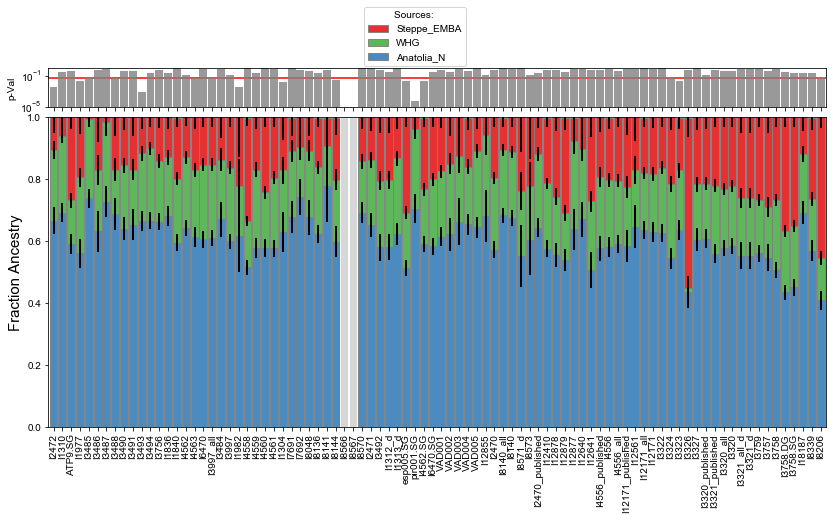

In [58]:
### Load the ancient Individual Label Data
pops = ["Iberia_BA", "Iberia_IA", "Iberia_Tartessian",
        "Iberia_Iberian", "Iberia_Celtiberian"]
path_ind = "./eigenstrat/combined/punic1.v43.ind"
add_iids = ["I18187", "I8339", "I8206"]   # "I18203" "I8207"

all_iids = [load_iids_from_indfile(path_ind=path_ind, 
                        string=pop) for pop in pops]
all_iids = [l for ls in all_iids for l in ls]
all_iids = all_iids + add_iids    #np.concatenate(all_iids)
paths = [".".join([iid, "Anatolia_N", "WHG", "Steppe_EMBA"]) for iid in all_iids]


dir_path = "./output/qpAdm/3wayIberia/"
save_path = "./output/figures/qpAdm/Iberia_3way.pdf"   # ./figures/qpAdm/4way_Canaanite_AfrIA.pdf
c = ["#377eb8", "#4daf4a", "#e41a1c"]

df_3way = plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path, 
            best=False, pval_lim = [1e-5,1], figsize=(12,6), bw=0.9, 
            fs=10, c=c, ec="gray", dataframe=True)

In [59]:
savepath = "./output/qpAdm/3wayIberia/3wayIberia.csv"
df_3way.to_csv(savepath, 
               sep="\t", index=None)
print(f"Saved {len(df_3way)} Individuals to {savepath}")

Saved 88 Individuals to ./output/qpAdm/3wayIberia/3wayIberia.csv


In [ ]:
df_all[df_all["Fraction_3"]<0.1]

# Area 51

In [16]:
df_ind = pd.read_csv("./eigenstrat/combined/punic1.v43.ind", delim_whitespace=True, header=None)
#path_ind = "./eigenstrat/combined/punic1.v43_mod.ind"
df_ind.columns = ["iid", "sex", "clst"]

In [ ]:
idx = df_ind["clst"].str.contains("Poliz")
df_ind[idx]

In [24]:
np.sum(idx)

19